# Livrable 2 - Débruitage d'image : 
    Notebook d'entrainememnt et d'étude de cas : séparation des jeux de données, encodage et normalisation pré-entrainement, entrainement avec callback et suivi par tensorboard pour finir avec une phase de bench mark.

Absctract :
    The images that are captured in the real world come with noises. These noises can appear due to many reasons such as electric signal instabilities, malfunctioning of camera sensors, poor lighting conditions, errors in data transmission over long distances, etc. This can degrade the captured image's quality and can cause loss of information as the original pixel values are replaced by random values due to noise. So, there is a need to remove these noises from images when it comes to low-level vision tasks and image processing. The process of removing such noises from images is known as Image Denoising.

## 1. Chargement des Bibliothèques

In [16]:
# %% [markdown]
# ## 1. Chargement des Bibliothèques
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
import keras.backend as K
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 2. Paramètres et Configuration

In [ ]:
IMG_SIZE = (256, 256) 
BATCH_SIZE = 8
EPOCHS = 100
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
DATA_PATH = '/home/kevin/datasets/livrable2/processed'

## 3. Chargement et Préparation des Données
Vérification des dossiers, lecture sécurisée, filtrage par extension, contrôle de taille, normalisation et split adaptatif (train/val/test).

In [ ]:
def load_data(data_path):
    # Vérification hiérarchique renforcée
    noisy_path = os.path.join(data_path, 'noisy')
    clean_path = os.path.join(data_path, 'clean')
    
    for path in [noisy_path, clean_path]:
        if not os.path.isdir(path):
            raise ValueError(f"Dossier introuvable: {path}")
    
    # Collecte avec vérification d'extension
    valid_ext = ['.jpg', '.jpeg', '.png']
    
    noisy_files = sorted([f for f in os.listdir(noisy_path) 
                         if os.path.splitext(f)[1].lower() in valid_ext])
    clean_files = sorted([f for f in os.listdir(clean_path)
                         if os.path.splitext(f)[1].lower() in valid_ext])

    # Lecture avec progression et gestion d'erreur
    noisy_imgs, clean_imgs = [], []
    for idx, (nfile, cfile) in enumerate(zip(noisy_files, clean_files)):
        noisy_img = cv2.imread(os.path.join(noisy_path, nfile))
        noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
        clean_img = cv2.imread(os.path.join(clean_path, cfile))
        clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)   
        
        if noisy_img is None:
            print(f"ERREUR: Échec de lecture de {nfile} (taille attendue: {IMG_SIZE})")
            continue
        if clean_img is None:
            print(f"ERREUR: Échec de lecture de {cfile} (taille attendue: {IMG_SIZE})")
            continue
        
        # Vérification de la taille
        if noisy_img.shape != (*IMG_SIZE, 3):
            print(f"Avertissement: {nfile} a une taille {noisy_img.shape}, ignoré")
            continue
            
        noisy_imgs.append(noisy_img)
        clean_imgs.append(clean_img)
        
        if (idx+1) % 10 == 0:
            print(f"Traité {idx+1}/{len(noisy_files)} paires")

    print(f"\nSuccès: {len(noisy_imgs)} paires valides sur {len(noisy_files)}")
    return np.array(noisy_imgs), np.array(clean_imgs)

# Chargement avec vérification
try:
    X_noisy, X_clean = load_data(DATA_PATH)
except Exception as e:
    print(f"Erreur: {e}")
    raise

# Vérification des dimensions
assert X_noisy.shape == X_clean.shape, "Dimensions incohérentes entre X_noisy et X_clean!"

# Normalisation [0,1]
X_noisy = X_noisy.astype('float32') / 255.0
X_clean = X_clean.astype('float32') / 255.0

# Split adaptatif pour petits datasets
TOTAL_SIZE = len(X_noisy)
print(f"Total d'images: {TOTAL_SIZE}")
if TOTAL_SIZE < 100:
    # Stratégie pour datasets réduits
    TEST_SPLIT = max(1, int(0.1 * TOTAL_SIZE))
    VAL_SPLIT = max(1, int(0.2 * TOTAL_SIZE))
else:
    TEST_SPLIT = 0.1
    VAL_SPLIT = 0.2

# Split avec shuffle stratifié
X_train, X_temp, y_train, y_temp = train_test_split(
    X_noisy, X_clean, 
    test_size=(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED,
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=TEST_SPLIT/(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED
)

print(f"\nSplit Final:")
print(f"- Train: {len(X_train)}")
print(f"- Val: {len(X_val)}")
print(f"- Test: {len(X_test)}")

Traité 10/298 paires
Traité 20/298 paires
Traité 30/298 paires
Traité 40/298 paires
Traité 50/298 paires
Traité 60/298 paires
Traité 70/298 paires
Traité 80/298 paires
Traité 90/298 paires
Traité 100/298 paires
Traité 110/298 paires
Traité 120/298 paires
Traité 130/298 paires
Traité 140/298 paires
Traité 150/298 paires
Traité 160/298 paires
Traité 170/298 paires
Traité 180/298 paires
Traité 190/298 paires
Traité 200/298 paires
Traité 210/298 paires
Traité 220/298 paires
Traité 230/298 paires
Traité 240/298 paires
Traité 250/298 paires
Traité 260/298 paires
Traité 270/298 paires
Traité 280/298 paires
Traité 290/298 paires

Succès: 298 paires valides sur 298
Total d'images: 298

Split Final:
- Train: 208
- Val: 60
- Test: 30


## 4. Définition du modèle avec ces blocks d'attention spatial
Pour plus de détails sur la base scientifique appuyant l'architecture utilisée : (https://paperswithcode.com/method/spatial-attention-module)

In [30]:
class SpatialAttention(layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.dense1 = layers.Dense(channels // self.ratio, activation='relu', 
                                  kernel_initializer='he_normal', use_bias=False)
        self.dense2 = layers.Dense(channels, activation='sigmoid', 
                                  kernel_initializer='he_normal', use_bias=False)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super(SpatialAttention, self).build(input_shape)

    def call(self, x):
        channels = x.shape[-1]
        
        # Channel attention branch
        avg_pool = layers.GlobalAveragePooling2D()(x)
        avg_pool = layers.Reshape((1, 1, channels))(avg_pool)
        avg_pool = self.dense1(avg_pool)
        avg_pool = self.dense2(avg_pool)
        
        # Spatial attention branch
        # Use tf.reduce_max instead of K.max
        max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
        # Use tf.reduce_mean instead of K.mean
        avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate()([max_pool, avg_pool_spatial])
        spatial = self.conv(concat)
        
        # Apply attention
        return x * avg_pool * spatial

def ResidualConvBlock(x, filters):
    """
    Creates a residual convolutional block.
    
    Args:
        x: Input tensor
        filters: Number of filters in the convolutional layers
        
    Returns:
        A tensor after applying residual convolutions
    """
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.Add()([shortcut, x])
    return x

def improved_unet(input_shape=(256,256,3)):
    """
    Creates an improved U-Net model with residual blocks and skip connections.
    
    Args:
        input_shape: Input shape of the images (height, width, channels)
        
    Returns:
        A compiled Keras model
    """
    inputs = layers.Input(input_shape)
    
    # Encoder with residual blocks
    e1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    e1 = ResidualConvBlock(e1, 64)
    p1 = layers.MaxPooling2D()(e1)
    
    e2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    e2 = ResidualConvBlock(e2, 128)
    p2 = layers.MaxPooling2D()(e2)
    
    # Bottleneck with attention and dropout
    bridge = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    bridge = SpatialAttention()(bridge)
    bridge = layers.Dropout(0.3)(bridge)
    
    # Decoder with skip connections
    d1 = layers.UpSampling2D()(bridge)
    d1 = layers.Concatenate()([d1, e2])
    d1 = layers.Conv2D(128, 3, activation='relu', padding='same')(d1)
    
    d2 = layers.UpSampling2D()(d1)
    d2 = layers.Concatenate()([d2, e1])
    d2 = layers.Conv2D(64, 3, activation='relu', padding='same')(d2)
    
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(d2)
    
    return Model(inputs, outputs)

## 5. Métriques Personnalisées + Callbacks Learning Rate et TensorBoard
- PSNR  
- SSIM  
- hybrid_loss (SSIM + MSE + perceptual loss via VGG)
- WarmUpAndCosineDecay (planning LR)
- LearningRateLogger  
- TensorBoard callback

In [ ]:
import datetime


def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

def hybrid_loss(y_true, y_pred):
    # Perte structurelle (déjà un scalaire)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
    # Perte de contenu (réduction explicite)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Perte perceptuelle (prétraitement VGG16)
    
    y_true_features = loss_model(y_true)
    y_pred_features = loss_model(y_pred)
    
    # Réduction explicite de la perte perceptuelle
    perceptual_loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))
    
    # Maintenant toutes les pertes sont des scalaires et peuvent être additionnées
    return 0.6*ssim_loss + 0.3*mse_loss + 0.1*perceptual_loss

class WarmUpAndCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, warmup_steps, total_steps, min_lr=1e-6):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        progress = (step - self.warmup_steps) / tf.maximum(1.0, self.total_steps - self.warmup_steps)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * progress))
        decayed_lr = (self.base_lr - self.min_lr) * cosine_decay + self.min_lr

        lr = tf.cond(
            step < self.warmup_steps,
            lambda: self.base_lr * (step / self.warmup_steps),
            lambda: decayed_lr
        )
        return lr

    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "min_lr": self.min_lr
        }

    
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if callable(lr):
            lr = lr(self.model.optimizer.iterations)
        print(f"\n📉 [Epoch {epoch+1}] Current Learning Rate: {lr:.6f}")



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=0
)

## 6. Compilation et Entraînement
- Création du modèle `improved_unet()`  
- AdamW + WarmUpAndCosineDecay  
- EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateLogger  
- Lancement de `model.fit`

In [ ]:
model = improved_unet()
initial_learning_rate = 1e-3
steps_per_epoch = len(X_train) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch

lr_schedule = WarmUpAndCosineDecay(
    base_lr=1e-3,
    warmup_steps=5 * steps_per_epoch,
    total_steps=total_steps,
    min_lr=1e-6
)

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)
model.compile(
    optimizer=optimizer,
    loss=hybrid_loss,
    metrics=[PSNR, SSIM]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "notebooks/livrable2/models/best_model-v3-unet.h5",
    save_best_only=True,
    monitor='val_loss',
    save_weights_only=False,
    verbose=1
)

lr_logger = LearningRateLogger()

### POUR LANCER TENSORBOARD ###
######## tensorboard --logdir=logs/fit 
### POUR LANCER TENSORBOARD ###


## Entraînement avec validation
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        checkpoint,
        tensorboard_cb,
        lr_logger
    ],
    verbose=1
)

Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 4:25 11s/step - loss: 5.5255 - psnr: 9.3957 - ssim: 0.0448

2025-04-18 10:56:21.397974: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 232 bytes spill stores, 232 bytes spill loads



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 5.4318 - psnr: 9.9055 - ssim: 0.0703
Epoch 1: val_loss improved from inf to 5.25063, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 1] Current Learning Rate: 0.000200
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - loss: 5.4185 - psnr: 9.8926 - ssim: 0.0720 - val_loss: 5.2506 - val_psnr: 10.8598 - val_ssim: 0.3387
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 4.0473 - psnr: 9.5702 - ssim: 0.2479
Epoch 2: val_loss improved from 5.25063 to 5.14141, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 2] Current Learning Rate: 0.000400
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 4.0427 - psnr: 9.6120 - ssim: 0.2490 - val_loss: 5.1414 - val_psnr: 11.4065 - val_ssim: 0.3653
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 3.4039 - psnr: 12.9904 - ssim: 0.3670
Epoch 3: val_loss improved from 5.14141 to 4.96858, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 3] Current Learning Rate: 0.000600
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 3.4029 - psnr: 13.0266 - ssim: 0.3676 - val_loss: 4.9686 - val_psnr: 11.8493 - val_ssim: 0.3837
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 3.1290 - psnr: 15.1894 - ssim: 0.4278
Epoch 4: val_loss did not improve from 4.96858

📉 [Epoch 4] Current Learning Rate: 0.000800
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 3.1288 - psnr: 15.2122 - ssim: 0.4281 - val_loss: 5.0320 - val_psnr: 12.0311 - val_ssim: 0.3834
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 2.8313 - psnr: 16.9309 - ssim: 0.4791
Epoch 5: val_loss did not improve from 4.96858

📉 [Epoch 5] Current Learning Rate: 0.001000
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 2.8283 - psnr: 16.9532 - ssim: 0.4797 - val_loss: 5.0774 - val_psnr: 11.7114 - val_ssim: 0.3679
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 2.2796 - psnr: 18.7711 - ssim: 0.5500
Epoch 6: val_loss improved from 4.96858


📉 [Epoch 6] Current Learning Rate: 0.001000
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 2.2762 - psnr: 18.7887 - ssim: 0.5506 - val_loss: 4.7590 - val_psnr: 11.6321 - val_ssim: 0.3506
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 1.9091 - psnr: 20.3355 - ssim: 0.6051
Epoch 7: val_loss improved from 4.75904 to 4.61951, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 7] Current Learning Rate: 0.000999
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 1.9090 - psnr: 20.3397 - ssim: 0.6053 - val_loss: 4.6195 - val_psnr: 12.2215 - val_ssim: 0.3790
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.7207 - psnr: 21.3656 - ssim: 0.6378
Epoch 8: val_loss improved from 4.61951 to 4.51626, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 8] Current Learning Rate: 0.000998
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - loss: 1.7203 - psnr: 21.3593 - ssim: 0.6379 - val_loss: 4.5163 - val_psnr: 12.4836 - val_ssim: 0.3856
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1.5298 - psnr: 21.8640 - ssim: 0.6622
Epoch 9: val_loss improved from 4.51626 to 4.22678, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 9] Current Learning Rate: 0.000996
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 1.5304 - psnr: 21.8621 - ssim: 0.6622 - val_loss: 4.2268 - val_psnr: 13.1640 - val_ssim: 0.4273
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1.4332 - psnr: 22.1652 - ssim: 0.6785
Epoch 10: val_loss improved from 4.22678 to 3.63907, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 10] Current Learning Rate: 0.000993
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 1.4337 - psnr: 22.1674 - ssim: 0.6784 - val_loss: 3.6391 - val_psnr: 13.9247 - val_ssim: 0.4652
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.3288 - psnr: 22.5063 - ssim: 0.6949
Epoch 11: val_loss improved from 3.63907 to 3.42189, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 11] Current Learning Rate: 0.000990
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 1.3291 - psnr: 22.5099 - ssim: 0.6948 - val_loss: 3.4219 - val_psnr: 14.1532 - val_ssim: 0.4815
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1.2604 - psnr: 22.6421 - ssim: 0.7069
Epoch 12: val_loss improved from 3.42189 to 2.93774, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 12] Current Learning Rate: 0.000987
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 1.2610 - psnr: 22.6454 - ssim: 0.7068 - val_loss: 2.9377 - val_psnr: 14.9184 - val_ssim: 0.5135
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1.2119 - psnr: 22.6807 - ssim: 0.7152
Epoch 13: val_loss improved from 2.93774 to 2.45436, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 13] Current Learning Rate: 0.000983
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 1.2124 - psnr: 22.6864 - ssim: 0.7152 - val_loss: 2.4544 - val_psnr: 15.6494 - val_ssim: 0.5520
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.1534 - psnr: 22.8405 - ssim: 0.7250
Epoch 14: val_loss improved from 2.45436 to 2.21281, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 14] Current Learning Rate: 0.000978
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - loss: 1.1540 - psnr: 22.8451 - ssim: 0.7249 - val_loss: 2.2128 - val_psnr: 16.1692 - val_ssim: 0.5771
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.1034 - psnr: 23.0617 - ssim: 0.7327
Epoch 15: val_loss improved from 2.21281 to 1.86315, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 15] Current Learning Rate: 0.000973
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 1.1039 - psnr: 23.0655 - ssim: 0.7327 - val_loss: 1.8631 - val_psnr: 17.4904 - val_ssim: 0.6189
Epoch 16/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.0561 - psnr: 23.2059 - ssim: 0.7401
Epoch 16: val_loss improved from 1.86315 to 1.67765, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 16] Current Learning Rate: 0.000967
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 1.0567 - psnr: 23.2067 - ssim: 0.7401 - val_loss: 1.6776 - val_psnr: 18.5097 - val_ssim: 0.6472
Epoch 17/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1.0211 - psnr: 23.2338 - ssim: 0.7450
Epoch 17: val_loss improved from 1.67765 to 1.49006, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 17] Current Learning Rate: 0.000961
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 1.0217 - psnr: 23.2347 - ssim: 0.7449 - val_loss: 1.4901 - val_psnr: 19.4826 - val_ssim: 0.6773
Epoch 18/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.9839 - psnr: 23.3693 - ssim: 0.7509
Epoch 18: val_loss improved from 1.49006 to 1.45068, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 18] Current Learning Rate: 0.000955
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.9844 - psnr: 23.3724 - ssim: 0.7509 - val_loss: 1.4507 - val_psnr: 19.7642 - val_ssim: 0.6868
Epoch 19/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.9577 - psnr: 23.4669 - ssim: 0.7561
Epoch 19: val_loss did not improve from 1.45068

📉 [Epoch 19] Current Learning Rate: 0.000947
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.9582 - psnr: 23.4708 - ssim: 0.7560 - val_loss: 1.4822 - val_psnr: 19.7976 - val_ssim: 0.6866
Epoch 20/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.9439 - psnr: 23.5270 - ssim: 0.7596
Epoch 20: val_loss improved from 1.45068 to 1.31725, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 20] Current Learning Rate: 0.000940
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.9444 - psnr: 23.5329 - ssim: 0.7596 - val_loss: 1.3173 - val_psnr: 21.0718 - val_ssim: 0.7147
Epoch 21/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.9199 - psnr: 23.7110 - ssim: 0.7640
Epoch 21: val_loss improved from 1.31725 to 1.19603, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 21] Current Learning Rate: 0.000932
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.9205 - psnr: 23.7142 - ssim: 0.7639 - val_loss: 1.1960 - val_psnr: 22.2806 - val_ssim: 0.7415
Epoch 22/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.8950 - psnr: 23.9593 - ssim: 0.7687
Epoch 22: val_loss did not improve from 1.19603

📉 [Epoch 22] Current Learning Rate: 0.000923
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.8955 - psnr: 23.9583 - ssim: 0.7686 - val_loss: 1.2784 - val_psnr: 21.9141 - val_ssim: 0.7326
Epoch 23/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.8875 - psnr: 23.9176 - ssim: 0.7693
Epoch 23: val_loss did not improve from 1.19603

📉 [Epoch 23] Current Learning Rate: 0.000914
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.8879 - psnr: 23.9178 - ssim: 0.7693 - val_loss: 1.2144 - val_psnr: 21.1295 - val_ssim: 0.7291
Epoch 24/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.9060 - psnr: 23.5611 - ssim: 0.7659
Epoch 24: val_loss did not impr


📉 [Epoch 25] Current Learning Rate: 0.000895
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.8928 - psnr: 23.7738 - ssim: 0.7696 - val_loss: 1.0773 - val_psnr: 23.3252 - val_ssim: 0.7645
Epoch 26/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.8462 - psnr: 24.0163 - ssim: 0.7779
Epoch 26: val_loss improved from 1.07730 to 0.97095, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 26] Current Learning Rate: 0.000884
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.8465 - psnr: 24.0162 - ssim: 0.7779 - val_loss: 0.9710 - val_psnr: 23.5610 - val_ssim: 0.7800
Epoch 27/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.8217 - psnr: 24.0644 - ssim: 0.7813
Epoch 27: val_loss improved from 0.97095 to 0.91411, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 27] Current Learning Rate: 0.000874
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.8219 - psnr: 24.0668 - ssim: 0.7813 - val_loss: 0.9141 - val_psnr: 24.1601 - val_ssim: 0.7834
Epoch 28/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.7911 - psnr: 24.2721 - ssim: 0.7856
Epoch 28: val_loss improved from 0.91411 to 0.88903, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 28] Current Learning Rate: 0.000862
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.7915 - psnr: 24.2723 - ssim: 0.7855 - val_loss: 0.8890 - val_psnr: 25.3588 - val_ssim: 0.7899
Epoch 29/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.7783 - psnr: 24.4886 - ssim: 0.7885
Epoch 29: val_loss improved from 0.88903 to 0.87862, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 29] Current Learning Rate: 0.000851
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.7788 - psnr: 24.4847 - ssim: 0.7884 - val_loss: 0.8786 - val_psnr: 25.8113 - val_ssim: 0.7916
Epoch 30/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.7667 - psnr: 24.5163 - ssim: 0.7903
Epoch 30: val_loss did not improve from 0.87862

📉 [Epoch 30] Current Learning Rate: 0.000839
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.7672 - psnr: 24.5155 - ssim: 0.7902 - val_loss: 0.9047 - val_psnr: 25.6805 - val_ssim: 0.7871
Epoch 31/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.7542 - psnr: 24.5398 - ssim: 0.7920
Epoch 31: val_loss did not improve from 0.87862

📉 [Epoch 31] Current Learning Rate: 0.000826
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.7547 - psnr: 24.5380 - ssim: 0.7919 - val_loss: 0.8964 - val_psnr: 25.6119 - val_ssim: 0.7871
Epoch 32/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.7465 - psnr: 24.6416 - ssim: 0.7937
Epoch 32: val_loss did not impr


📉 [Epoch 34] Current Learning Rate: 0.000787
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.7354 - psnr: 24.6221 - ssim: 0.7948 - val_loss: 0.8594 - val_psnr: 25.9791 - val_ssim: 0.7963
Epoch 35/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.7265 - psnr: 24.7400 - ssim: 0.7972
Epoch 35: val_loss improved from 0.85936 to 0.85458, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 35] Current Learning Rate: 0.000774
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.7268 - psnr: 24.7338 - ssim: 0.7971 - val_loss: 0.8546 - val_psnr: 25.9911 - val_ssim: 0.7916
Epoch 36/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.7122 - psnr: 24.8434 - ssim: 0.8000
Epoch 36: val_loss improved from 0.85458 to 0.82528, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 36] Current Learning Rate: 0.000760
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.7126 - psnr: 24.8412 - ssim: 0.7999 - val_loss: 0.8253 - val_psnr: 26.1917 - val_ssim: 0.7996
Epoch 37/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.7036 - psnr: 24.7875 - ssim: 0.8013
Epoch 37: val_loss did not improve from 0.82528

📉 [Epoch 37] Current Learning Rate: 0.000745
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.7041 - psnr: 24.7872 - ssim: 0.8013 - val_loss: 0.8393 - val_psnr: 25.7407 - val_ssim: 0.7913
Epoch 38/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.6982 - psnr: 24.8252 - ssim: 0.8015
Epoch 38: val_loss improved from 0.82528 to 0.82042, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 38] Current Learning Rate: 0.000731
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.6987 - psnr: 24.8229 - ssim: 0.8015 - val_loss: 0.8204 - val_psnr: 25.7157 - val_ssim: 0.7940
Epoch 39/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.6877 - psnr: 24.7473 - ssim: 0.8012
Epoch 39: val_loss did not improve from 0.82042

📉 [Epoch 39] Current Learning Rate: 0.000716
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.6882 - psnr: 24.7454 - ssim: 0.8012 - val_loss: 0.8380 - val_psnr: 25.7175 - val_ssim: 0.7936
Epoch 40/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.6803 - psnr: 24.7528 - ssim: 0.8027
Epoch 40: val_loss did not improve from 0.82042

📉 [Epoch 40] Current Learning Rate: 0.000701
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.6808 - psnr: 24.7512 - ssim: 0.8026 - val_loss: 0.8515 - val_psnr: 25.5684 - val_ssim: 0.7981
Epoch 41/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.6771 - psnr: 24.7758 - ssim: 0.8037
Epoch 41: val_loss did not impr


📉 [Epoch 44] Current Learning Rate: 0.000639
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.6584 - psnr: 25.0004 - ssim: 0.8075 - val_loss: 0.8041 - val_psnr: 26.1260 - val_ssim: 0.8092
Epoch 45/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.6546 - psnr: 25.1142 - ssim: 0.8083
Epoch 45: val_loss improved from 0.80410 to 0.80171, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 45] Current Learning Rate: 0.000623
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.6552 - psnr: 25.1125 - ssim: 0.8082 - val_loss: 0.8017 - val_psnr: 25.8144 - val_ssim: 0.8049
Epoch 46/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6691 - psnr: 24.7419 - ssim: 0.8061
Epoch 46: val_loss improved from 0.80171 to 0.78184, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 46] Current Learning Rate: 0.000607
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.6695 - psnr: 24.7426 - ssim: 0.8060 - val_loss: 0.7818 - val_psnr: 25.8642 - val_ssim: 0.8025
Epoch 47/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.6725 - psnr: 24.5192 - ssim: 0.8037
Epoch 47: val_loss did not improve from 0.78184

📉 [Epoch 47] Current Learning Rate: 0.000591
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.6729 - psnr: 24.5219 - ssim: 0.8037 - val_loss: 0.8259 - val_psnr: 25.5828 - val_ssim: 0.8086
Epoch 48/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6598 - psnr: 24.6705 - ssim: 0.8064
Epoch 48: val_loss did not improve from 0.78184

📉 [Epoch 48] Current Learning Rate: 0.000575
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.6600 - psnr: 24.6748 - ssim: 0.8064 - val_loss: 0.8000 - val_psnr: 25.8475 - val_ssim: 0.8009
Epoch 49/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.6417 - psnr: 24.8823 - ssim: 0.8096
Epoch 49: val_loss improved fro


📉 [Epoch 49] Current Learning Rate: 0.000558
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.6420 - psnr: 24.8864 - ssim: 0.8095 - val_loss: 0.7686 - val_psnr: 26.0710 - val_ssim: 0.8050
Epoch 50/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.6358 - psnr: 24.8426 - ssim: 0.8107
Epoch 50: val_loss improved from 0.76862 to 0.75732, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 50] Current Learning Rate: 0.000542
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.6362 - psnr: 24.8453 - ssim: 0.8107 - val_loss: 0.7573 - val_psnr: 26.0905 - val_ssim: 0.8116
Epoch 51/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.6369 - psnr: 24.7326 - ssim: 0.8105
Epoch 51: val_loss did not improve from 0.75732

📉 [Epoch 51] Current Learning Rate: 0.000525
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.6374 - psnr: 24.7336 - ssim: 0.8105 - val_loss: 0.7772 - val_psnr: 25.7689 - val_ssim: 0.8126
Epoch 52/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6361 - psnr: 24.6636 - ssim: 0.8104
Epoch 52: val_loss did not improve from 0.75732

📉 [Epoch 52] Current Learning Rate: 0.000509
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.6364 - psnr: 24.6660 - ssim: 0.8103 - val_loss: 0.7797 - val_psnr: 25.4924 - val_ssim: 0.8060
Epoch 53/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.6301 - psnr: 24.7305 - ssim: 0.8105
Epoch 53: val_loss did not impr


📉 [Epoch 57] Current Learning Rate: 0.000426
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.5864 - psnr: 25.3272 - ssim: 0.8187 - val_loss: 0.7568 - val_psnr: 25.7370 - val_ssim: 0.8165
Epoch 58/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5790 - psnr: 25.3837 - ssim: 0.8191
Epoch 58: val_loss improved from 0.75682 to 0.73627, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 58] Current Learning Rate: 0.000410
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.5794 - psnr: 25.3831 - ssim: 0.8191 - val_loss: 0.7363 - val_psnr: 25.9021 - val_ssim: 0.8170
Epoch 59/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5743 - psnr: 25.3809 - ssim: 0.8190
Epoch 59: val_loss improved from 0.73627 to 0.72318, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 59] Current Learning Rate: 0.000394
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.5746 - psnr: 25.3807 - ssim: 0.8190 - val_loss: 0.7232 - val_psnr: 26.2899 - val_ssim: 0.8177
Epoch 60/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5663 - psnr: 25.4914 - ssim: 0.8195
Epoch 60: val_loss improved from 0.72318 to 0.71809, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 60] Current Learning Rate: 0.000378
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.5666 - psnr: 25.4901 - ssim: 0.8195 - val_loss: 0.7181 - val_psnr: 26.6511 - val_ssim: 0.8202
Epoch 61/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5597 - psnr: 25.5456 - ssim: 0.8203
Epoch 61: val_loss improved from 0.71809 to 0.71719, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 61] Current Learning Rate: 0.000362
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.5601 - psnr: 25.5445 - ssim: 0.8203 - val_loss: 0.7172 - val_psnr: 26.8061 - val_ssim: 0.8226
Epoch 62/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5557 - psnr: 25.5898 - ssim: 0.8216
Epoch 62: val_loss did not improve from 0.71719

📉 [Epoch 62] Current Learning Rate: 0.000346
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.5561 - psnr: 25.5895 - ssim: 0.8215 - val_loss: 0.7190 - val_psnr: 26.7951 - val_ssim: 0.8220
Epoch 63/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5549 - psnr: 25.6224 - ssim: 0.8218
Epoch 63: val_loss improved from 0.71719 to 0.71178, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 63] Current Learning Rate: 0.000331
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.5552 - psnr: 25.6226 - ssim: 0.8218 - val_loss: 0.7118 - val_psnr: 26.7344 - val_ssim: 0.8213
Epoch 64/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.5542 - psnr: 25.6236 - ssim: 0.8214
Epoch 64: val_loss did not improve from 0.71178

📉 [Epoch 64] Current Learning Rate: 0.000315
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.5546 - psnr: 25.6242 - ssim: 0.8214 - val_loss: 0.7171 - val_psnr: 26.6153 - val_ssim: 0.8180
Epoch 65/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.5501 - psnr: 25.6401 - ssim: 0.8217
Epoch 65: val_loss did not improve from 0.71178

📉 [Epoch 65] Current Learning Rate: 0.000300
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.5504 - psnr: 25.6415 - ssim: 0.8217 - val_loss: 0.7203 - val_psnr: 26.6286 - val_ssim: 0.8200
Epoch 66/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.5455 - psnr: 25.7188 - ssim: 0.8230
Epoch 66: val_loss did not impr


📉 [Epoch 73] Current Learning Rate: 0.000187
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.5312 - psnr: 25.8093 - ssim: 0.8253 - val_loss: 0.6991 - val_psnr: 26.5125 - val_ssim: 0.8232
Epoch 74/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.5260 - psnr: 25.8841 - ssim: 0.8256
Epoch 74: val_loss improved from 0.69914 to 0.69266, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 74] Current Learning Rate: 0.000175
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.5262 - psnr: 25.8813 - ssim: 0.8255 - val_loss: 0.6927 - val_psnr: 26.1968 - val_ssim: 0.8223
Epoch 75/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5199 - psnr: 25.9404 - ssim: 0.8262
Epoch 75: val_loss did not improve from 0.69266

📉 [Epoch 75] Current Learning Rate: 0.000162
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.5202 - psnr: 25.9383 - ssim: 0.8262 - val_loss: 0.6928 - val_psnr: 25.6702 - val_ssim: 0.8213
Epoch 76/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.5156 - psnr: 25.9269 - ssim: 0.8265
Epoch 76: val_loss did not improve from 0.69266

📉 [Epoch 76] Current Learning Rate: 0.000150
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.5159 - psnr: 25.9264 - ssim: 0.8265 - val_loss: 0.6935 - val_psnr: 25.7924 - val_ssim: 0.8231
Epoch 77/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5122 - psnr: 25.9132 - ssim: 0.8272
Epoch 77: val_loss did not impr


📉 [Epoch 81] Current Learning Rate: 0.000096
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.5033 - psnr: 25.9831 - ssim: 0.8294 - val_loss: 0.6926 - val_psnr: 25.9573 - val_ssim: 0.8251
Epoch 82/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4996 - psnr: 25.9973 - ssim: 0.8298
Epoch 82: val_loss improved from 0.69264 to 0.68919, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 82] Current Learning Rate: 0.000087
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.4998 - psnr: 26.0005 - ssim: 0.8298 - val_loss: 0.6892 - val_psnr: 26.0178 - val_ssim: 0.8251
Epoch 83/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.4981 - psnr: 26.0193 - ssim: 0.8302
Epoch 83: val_loss improved from 0.68919 to 0.68599, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 83] Current Learning Rate: 0.000078
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.4983 - psnr: 26.0228 - ssim: 0.8302 - val_loss: 0.6860 - val_psnr: 26.1597 - val_ssim: 0.8251
Epoch 84/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.4964 - psnr: 26.0176 - ssim: 0.8304
Epoch 84: val_loss improved from 0.68599 to 0.68284, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 84] Current Learning Rate: 0.000069
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.4967 - psnr: 26.0218 - ssim: 0.8303 - val_loss: 0.6828 - val_psnr: 26.3142 - val_ssim: 0.8252
Epoch 85/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4950 - psnr: 26.0201 - ssim: 0.8305
Epoch 85: val_loss improved from 0.68284 to 0.67952, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 85] Current Learning Rate: 0.000061
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.4953 - psnr: 26.0249 - ssim: 0.8305 - val_loss: 0.6795 - val_psnr: 26.4479 - val_ssim: 0.8254
Epoch 86/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.4941 - psnr: 26.0268 - ssim: 0.8306
Epoch 86: val_loss improved from 0.67952 to 0.67631, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 86] Current Learning Rate: 0.000054
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.4944 - psnr: 26.0321 - ssim: 0.8305 - val_loss: 0.6763 - val_psnr: 26.5865 - val_ssim: 0.8255
Epoch 87/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.4927 - psnr: 26.0397 - ssim: 0.8306
Epoch 87: val_loss improved from 0.67631 to 0.67370, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 87] Current Learning Rate: 0.000046
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.4929 - psnr: 26.0454 - ssim: 0.8306 - val_loss: 0.6737 - val_psnr: 26.6570 - val_ssim: 0.8253
Epoch 88/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.4913 - psnr: 26.0532 - ssim: 0.8304
Epoch 88: val_loss improved from 0.67370 to 0.67301, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 88] Current Learning Rate: 0.000040
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.4915 - psnr: 26.0594 - ssim: 0.8304 - val_loss: 0.6730 - val_psnr: 26.7130 - val_ssim: 0.8244
Epoch 89/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.4903 - psnr: 26.0742 - ssim: 0.8299
Epoch 89: val_loss improved from 0.67301 to 0.67236, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 89] Current Learning Rate: 0.000034
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.4906 - psnr: 26.0809 - ssim: 0.8299 - val_loss: 0.6724 - val_psnr: 26.7635 - val_ssim: 0.8242
Epoch 90/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.4892 - psnr: 26.0933 - ssim: 0.8294
Epoch 90: val_loss improved from 0.67236 to 0.67143, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 90] Current Learning Rate: 0.000028
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.4894 - psnr: 26.1002 - ssim: 0.8295 - val_loss: 0.6714 - val_psnr: 26.8174 - val_ssim: 0.8249
Epoch 91/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.4874 - psnr: 26.1131 - ssim: 0.8294
Epoch 91: val_loss improved from 0.67143 to 0.67132, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 91] Current Learning Rate: 0.000023
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.4877 - psnr: 26.1197 - ssim: 0.8295 - val_loss: 0.6713 - val_psnr: 26.8606 - val_ssim: 0.8255
Epoch 92/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4855 - psnr: 26.1309 - ssim: 0.8299
Epoch 92: val_loss did not improve from 0.67132

📉 [Epoch 92] Current Learning Rate: 0.000018
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.4857 - psnr: 26.1372 - ssim: 0.8300 - val_loss: 0.6717 - val_psnr: 26.9049 - val_ssim: 0.8258
Epoch 93/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4841 - psnr: 26.1497 - ssim: 0.8305
Epoch 93: val_loss improved from 0.67132 to 0.67131, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 93] Current Learning Rate: 0.000014
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.4844 - psnr: 26.1556 - ssim: 0.8305 - val_loss: 0.6713 - val_psnr: 26.9125 - val_ssim: 0.8258
Epoch 94/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4836 - psnr: 26.1655 - ssim: 0.8307
Epoch 94: val_loss improved from 0.67131 to 0.67096, saving model to notebooks/livrable2/models/best_model-v3-unet.h5



📉 [Epoch 94] Current Learning Rate: 0.000011
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.4839 - psnr: 26.1712 - ssim: 0.8307 - val_loss: 0.6710 - val_psnr: 26.9288 - val_ssim: 0.8258
Epoch 95/100
Epoch 95/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.4830 - psnr: 26.1756 - ssim: 0.8308
Epoch 95: val_loss did not improve from 0.67096

📉 [Epoch 95] Current Learning Rate: 0.000008
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.4832 - psnr: 26.1813 - ssim: 0.8308 - val_loss: 0.6710 - val_psnr: 26.9377 - val_ssim: 0.8258
Epoch 96/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.4822 - psnr: 26.1824 - ssim: 0.8309
Epoch 96: val_loss did not improve from 0.67096

📉 [Epoch 96] Current Learning Rate: 0.000005
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.4825 - psnr: 26.1879 - ssim: 0.8309 - val_loss: 0.6710 - val_psnr: 26.9424 - val_ssim: 0.8259
Epoch 97/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.4820 - psnr: 26.1855 - ssim: 0.8309
Epoch 97: val_loss

In [33]:
## Load the best model
model = tf.keras.models.load_model("notebooks/livrable2/models/best_model-v3-unet.h5",
        custom_objects={
        'PSNR': PSNR,
        'SSIM': SSIM,
        'hybrid_loss': hybrid_loss,
        'SpatialAttention': SpatialAttention,  # Ajout de la couche custom
        'WarmUpAndCosineDecay': WarmUpAndCosineDecay,  # Ajout de la fonction de planification du LR
    })

## Les custom object font qu'il fasse charger le modèle avec les bonnes métriques et la bonne loss en executant les cellule d'avant l'entrainement

## 7. Évaluation Quantitative
Calcul et affichage de la loss, du PSNR et du SSIM sur le set de test.

In [ ]:
test_results = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_results[0]}, PSNR: {test_results[1]}, SSIM: {test_results[2]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6038 - psnr: 27.5311 - ssim: 0.8324
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6038 - psnr: 27.5311 - ssim: 0.8324
Test Loss: 0.6038141846656799, PSNR: 27.531110763549805, SSIM: 0.8324003219604492


## 8. Visualisation des Résultats
Affichage des images bruitées, débruitées et originales côte à côte pour un échantillon de test.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


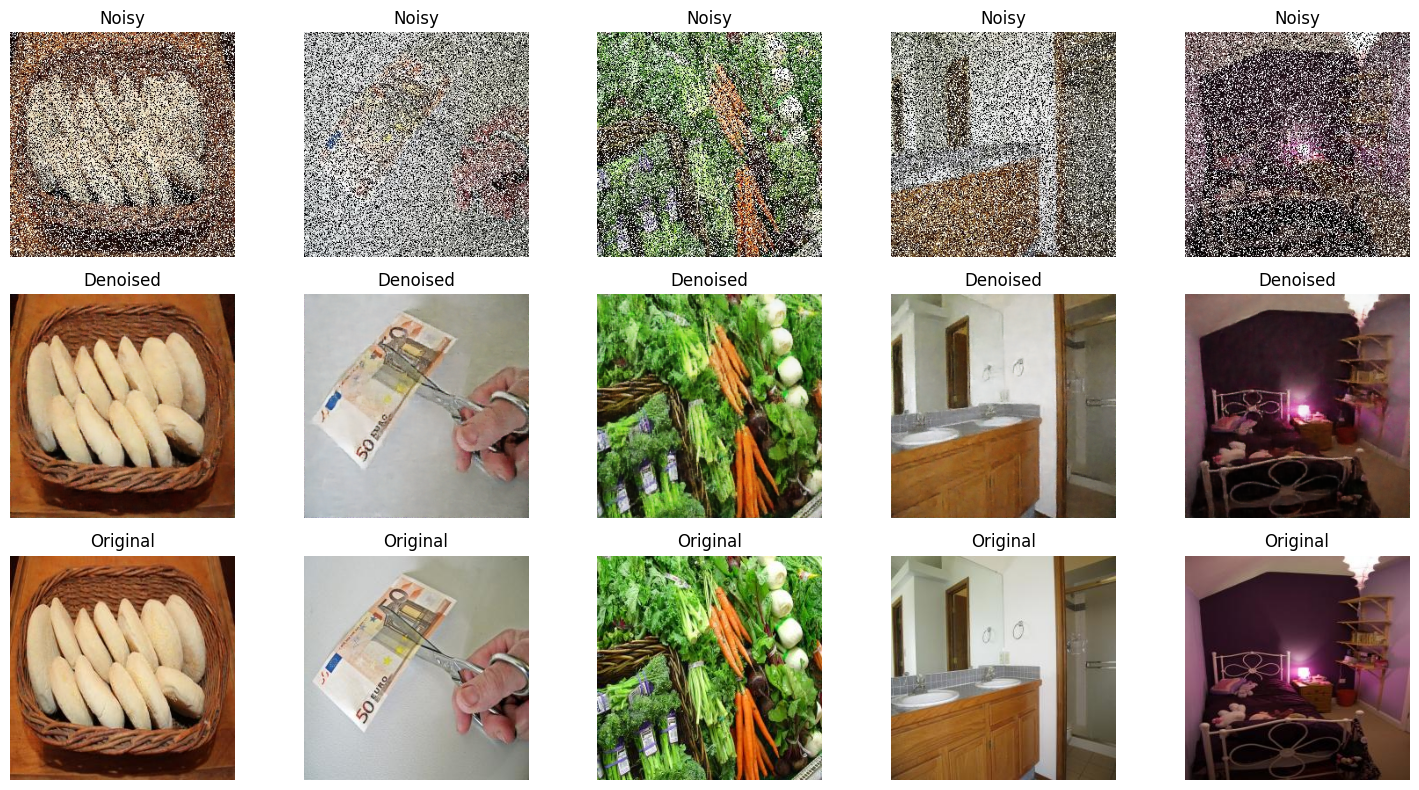

In [ ]:
def plot_results(n=5):
    plt.figure(figsize=(15,8))
    predictions = model.predict(X_test[:n])
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(X_test[i])
        plt.title("Noisy")
        plt.axis('off')
        
        plt.subplot(3, n, i+1+n)
        plt.imshow(predictions[i])
        plt.title("Denoised")
        plt.axis('off')
        
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(y_test[i])
        plt.title("Original")
        plt.axis('off')
    
    # Add padding between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    plt.show()

plot_results()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


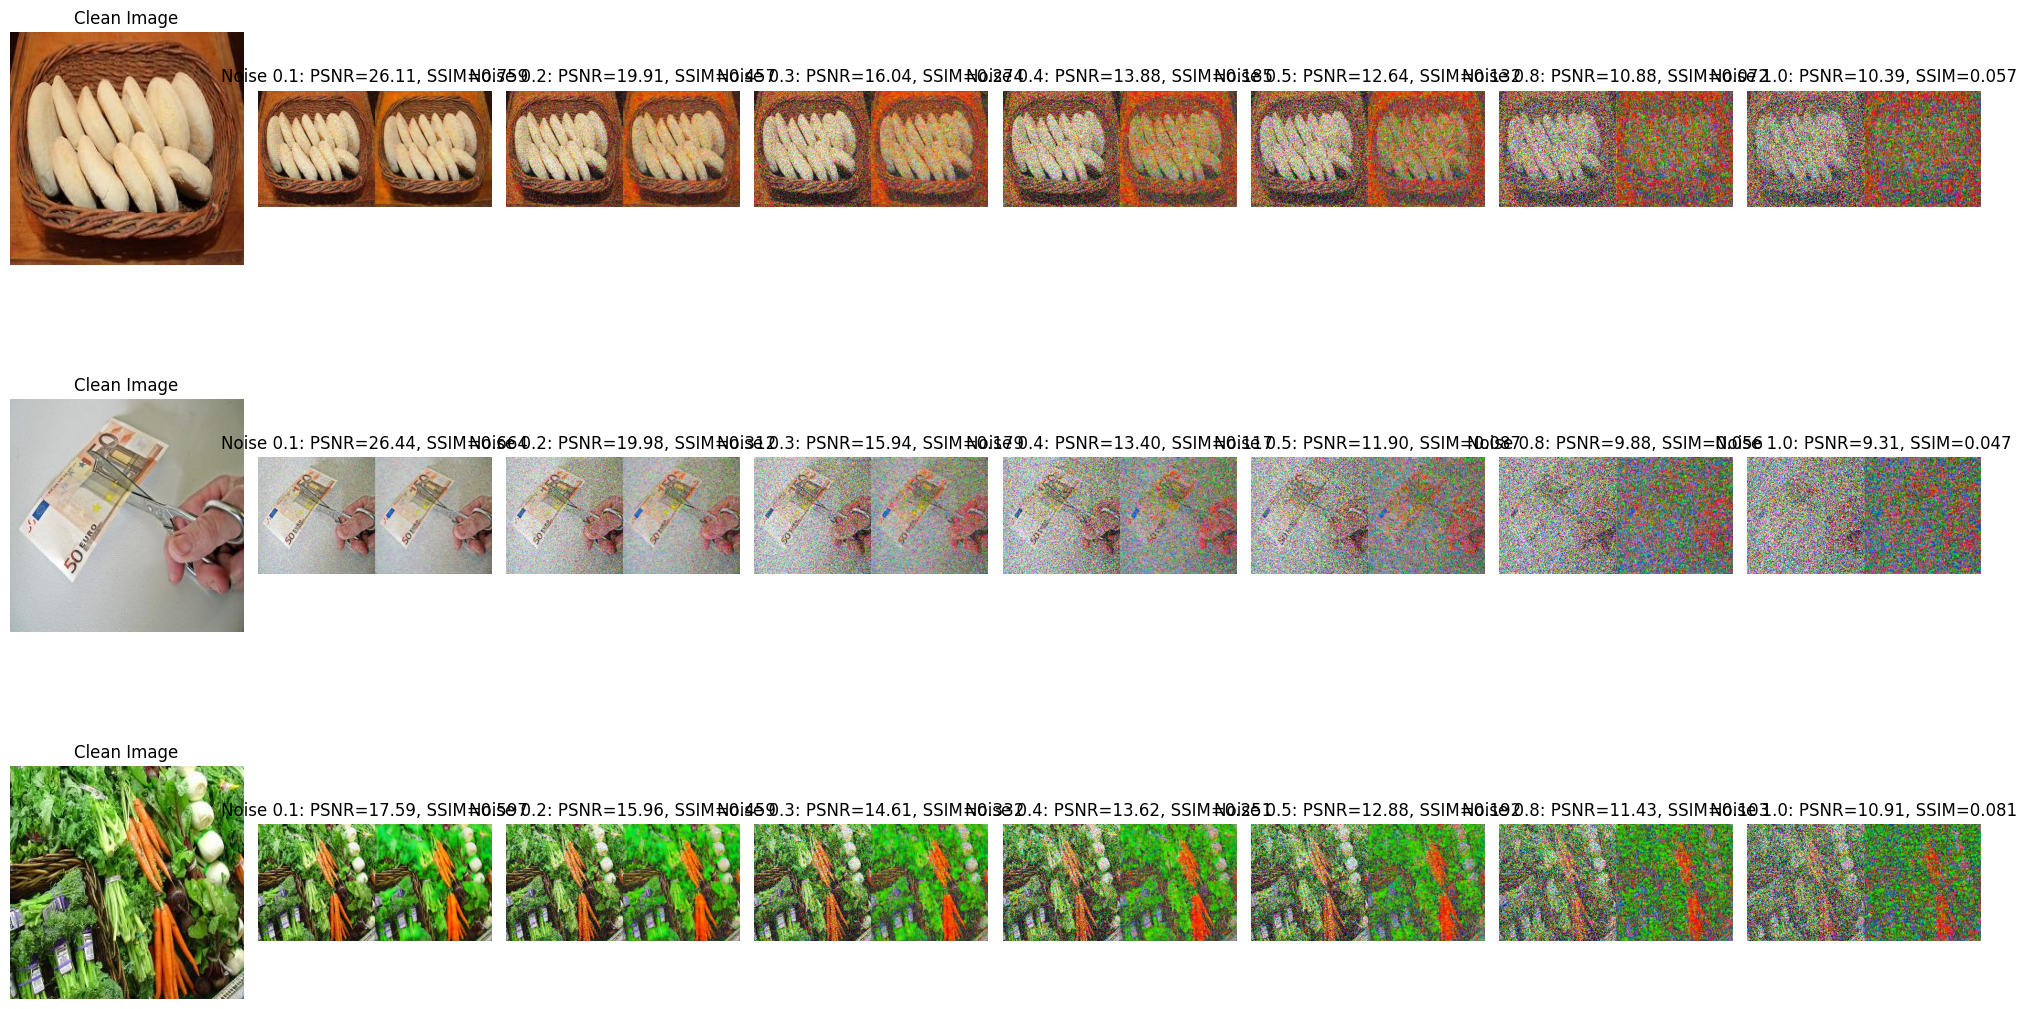

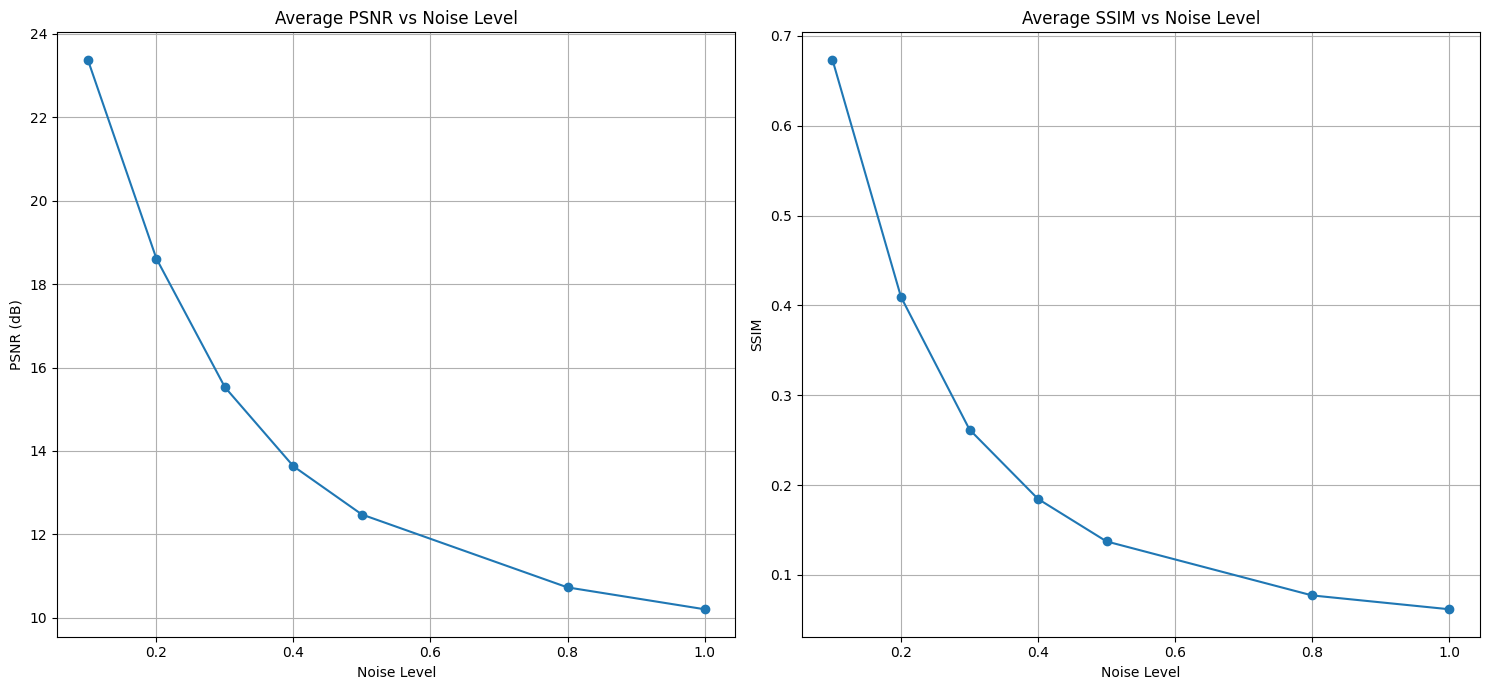

In [36]:
## Try to predict on clean image with deiffenrent noise level from 0.1 to 1
def add_gaussian_noise(image, noise_level):
    """
    Add Gaussian noise to an image
    
    Args:
        image: Clean image (normalized to [0,1])
        noise_level: Standard deviation of the noise
    
    Returns:
        Noisy image clipped to [0,1] range
    """
    noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip to valid range

# Select a few clean images from test set
num_samples = 3
selected_images = y_test[:num_samples]

# Define noise levels to test
noise_levels = [0.1,0.2,0.3,0.4,0.5,0.8,1.0]

# Create a figure for visualization
plt.figure(figsize=(20, 4*num_samples))

# Store metrics for each noise level
metrics = {level: {'psnr': [], 'ssim': []} for level in noise_levels}

for i, clean_img in enumerate(selected_images):
    # Show original clean image
    plt.subplot(num_samples, len(noise_levels) + 1, i*(len(noise_levels) + 1) + 1)
    plt.imshow(clean_img)
    plt.title("Clean Image")
    plt.axis('off')
    
    # Process each noise level
    for j, noise_level in enumerate(noise_levels):
        # Create noisy image
        noisy_img = add_gaussian_noise(clean_img, noise_level)
        
        # Predict (denoise)
        denoised_img = model.predict(np.expand_dims(noisy_img, axis=0))[0]
        
        # Calculate metrics
        psnr_val = psnr(clean_img, denoised_img)
        ssim_val = ssim(clean_img, denoised_img, channel_axis=-1, win_size=5, data_range=1.0)
        metrics[noise_level]['psnr'].append(psnr_val)
        metrics[noise_level]['ssim'].append(ssim_val)
        
        # Display noisy and denoised
        plt.subplot(num_samples, len(noise_levels) + 1, i*(len(noise_levels) + 1) + j + 2)
        
        # Create a side-by-side comparison
        comparison = np.hstack((noisy_img, denoised_img))
        plt.imshow(comparison)
        plt.title(f"Noise {noise_level}: PSNR={psnr_val:.2f}, SSIM={ssim_val:.3f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate average metrics for each noise level
avg_metrics = {level: {'psnr': np.mean(values['psnr']), 
                       'ssim': np.mean(values['ssim'])} 
              for level, values in metrics.items()}

# Plot average metrics vs noise level
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, [avg_metrics[level]['psnr'] for level in noise_levels], 'o-')
plt.title('Average PSNR vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('PSNR (dB)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels, [avg_metrics[level]['ssim'] for level in noise_levels], 'o-')
plt.title('Average SSIM vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('SSIM')
plt.grid(True)

plt.tight_layout()
plt.show()

### Tests sur le dossier de dépôt
Chargement des images d’un dossier externe, inférence et sauvegarde des résultats débruités.


In [43]:
## Tests on deposit folder, inference on new images
def load_and_preprocess_image(image_path):
    """
    Load and preprocess an image for the model.
    
    Args:
        image_path: Path to the image file
        
    Returns:
        Preprocessed image
    """
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype('float32') / 255.0
    return img 

for filename in os.listdir('notebooks/livrable2/tests_deposit'):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join('notebooks/livrable2/tests_deposit', filename)
        img = load_and_preprocess_image(image_path)
        denoised_img = model.predict(np.expand_dims(img, axis=0))[0]
        
        # Save the denoised image
        output_path = os.path.join('notebooks/livrable2/tests_deposit/tests_processed', filename)
        cv2.imwrite(output_path, (denoised_img * 255).astype('uint8'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


## Conclusion

Ce modèle démontre des performances très satisfaisantes pour le scénario spécifique pour lequel il a été conçu, notamment la dégradation sévère des images par du bruit de type *salt & pepper*.

Toutefois, il présente naturellement des limitations lorsqu'il est confronté à des bruits différents de ceux utilisés durant l'entraînement. Cette limitation n'est pas une faiblesse de conception du modèle, mais reflète une réalité générale dans le domaine du débruitage d'image : il n'existe pas de solution universelle. En effet, en traitement d'image et en vision par ordinateur, les modèles sont souvent spécialisés selon la nature spécifique du bruit (capteurs de smartphones, capteurs optiques dédiés, interférences radio en imagerie médicale, etc.).

Ce notebook constitue ainsi la première étape de notre démarche visant à créer un autoencodeur convolutif (AEC) optimisé pour le débruitage d'images. Nous avons validé l'efficacité de l'architecture choisie, mais avons également identifié la nécessité d'améliorer notre approche de prétraitement pour rendre notre modèle plus robuste à divers types de bruits. Une nouvelle pipeline de prétraitement, toujours basée sur notre jeu de données initial composé de 148 images, sera donc développée et évaluée dans :

- [Pipeline v2 pour Data Augmentation (4 types de bruit, 5 variances)] : `notebooks\livrable2\processing\pipeline-v2-dataaug.py`
- [Notebook entraînement et tests (étude de cas)] : `notebooks\livrable2\training\aec-v3-dataaug.py`

Dans une optique d'amélioration continue et de pertinence opérationnelle, il nous est également apparu indispensable de revoir en profondeur notre méthodologie pour traiter des cas réels, où les images présentent souvent des dimensions et résolutions variées. Limités initialement par notre puissance de calcul locale, nous étions contraints à traiter exclusivement des images de 256x256 pixels. Afin de contourner cette contrainte, nous avons adopté une stratégie basée sur le traitement par \"patchs\" (*patch processing*), permettant ainsi d'appliquer efficacement notre modèle sur des images à haute résolution :

- [Pipeline v3 pour Patch processing (10 patchs par images, patch de 32*32)] : `notebooks\livrable2\processing\pipeline-v3-patch.py`
- [Notebook entrainement et tests du patch processing] : `notebooks\livrable2\training\aec-v3-patch.py`
